In [1]:
!pip install edlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.6/305.6 KB 6.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
import emoji
import edlib
from tqdm import tqdm
from collections import Counter

In [3]:
PATH_TO_DATA_FOLDER = "../input/kontyp-panorama-tg"
data = pd.read_json(os.path.join(PATH_TO_DATA_FOLDER,'result.json'))

In [4]:
data['messages'].sample(4).values

array([{'id': 4376, 'type': 'message', 'date': '2020-07-17T11:30:04', 'from': 'ИА «Панорама»', 'from_id': 'channel1309900485', 'text': ['Юрия Шевчука вызвали на допрос из-за исполнения нелитованных песен в Германии\n\nТекст: Борис Гонтермахер\nЧитать полностью: ', {'type': 'link', 'text': 'https://panorama.pub/42764-shevchuka-vyzvali-na-dopros.html'}, '']},
       {'id': 7292, 'type': 'message', 'date': '2021-03-16T13:55:20', 'from': 'ИА «Панорама»', 'from_id': 'channel1309900485', 'photo': '(File not included. Change data exporting settings to download.)', 'width': 780, 'height': 520, 'text': [{'type': 'bold', 'text': '⚡️Песков ответил на вопрос о колебаниях цен на продукты\n\n'}, '«Цены могут как повышаться, так и понижаться. При этом платить необходимо больше, если цены выросли, или меньше, если они снизились», – пояснил пресс-секретарь президента']},
       {'id': 8584, 'type': 'message', 'date': '2021-06-07T19:13:19', 'from': 'ИА «Панорама»', 'from_id': 'channel1309900485', 'photo

Посмотрим на типы данных, которые будут находиться в поле json 'text'

In [5]:
types = list()

def collect_types(data):
    if 'text' in data:
        types.append(type(data['text']))

data['messages'].apply(lambda x: collect_types(x))
None

In [6]:
Counter(types)

Counter({str: 660, list: 10981})

In [7]:
data['messages'].apply(lambda x: x if isinstance(x.get('text'), str) else None).dropna().sample(4).values

array([{'id': 11011, 'type': 'service', 'date': '2021-12-20T18:03:30', 'actor': 'ИА «Панорама»', 'actor_id': 'channel1309900485', 'action': 'pin_message', 'message_id': 11010, 'text': ''},
       {'id': 4768, 'type': 'message', 'date': '2020-08-28T17:10:19', 'from': 'ИА «Панорама»', 'from_id': 'channel1309900485', 'forwarded_from': 'Элитное СМИ', 'text': 'Петербургской компании грозит полумиллионный штраф за непристойную рекламу с сосисками\n\nВ самом центре Петербурга находится ресторан «Щелкунчик», который для наружной рекламы выбрал слишком очевидную аналогию, сравнив сосиску с мужским половым органом. Креатив оценили не все. Например, Федеральной антимонопольной службе он пришёлся не по вкусу.\n\nВ действиях рекламодателя ООО «Династия» нашли нарушение закона о рекламе. За это компанию ждет штраф в размере от 100 тысяч до полумиллиона рублей. В ведомстве посчитали такую рекламу недостойной культурной столицы и впредь пообещали пресекать подобные попытки.\n\nЖителям Петербурга больш

In [8]:
data['messages'].apply(lambda x: x if isinstance(x.get('text'), list) else None).dropna().sample(4).values

array([{'id': 5015, 'type': 'message', 'date': '2020-09-19T10:00:04', 'from': 'ИА «Панорама»', 'from_id': 'channel1309900485', 'text': ['Джо Байден пожаловался на некачественный китайский чип в голове\n\nТекст: Бронислав Рубенштейн\nЧитать полностью: ', {'type': 'link', 'text': 'https://panorama.pub/47947-dzho-bajden-pozhalovalsya.html'}, '']},
       {'id': 11636, 'type': 'message', 'date': '2022-02-14T13:14:03', 'edited': '2022-02-14T13:14:55', 'from': 'ИА «Панорама»', 'from_id': 'channel1309900485', 'text': ['«Газпром» объявил о плановой остановке на ремонт газопроводов, ведущих в Европу\n\nТекст: Виталий Манн\nПродолжение: ', {'type': 'link', 'text': 'https://panorama.wtf/14768'}, '']},
       {'id': 9362, 'type': 'message', 'date': '2021-08-03T14:29:01', 'from': 'ИА «Панорама»', 'from_id': 'channel1309900485', 'photo': '(File not included. Change data exporting settings to download.)', 'width': 959, 'height': 527, 'text': [{'type': 'bold', 'text': '⚡️Вместо препарата «Спутник V» Р

В поле 'text' находится тип list, если в телеграм посте находится гиперссылка или хештег, и str, если ее нет. Если в данных str, то используем часть текста до первого переноса строки. Если в данных dict, то появляется несколько случаев из-за того, что оформление постов менялось со временем. Для каждой строки дополнительно проведем отчистку от емоджи.

In [9]:
LEN_THRESHOLD = 10
MIN_WORDS_THRESHOLD = 4
MAX_WORDS_THRESHOLD = 30
messages = list()

def sanitize(text):
    if text:
        text = text.splitlines()[0]
        text = emoji.replace_emoji(text, replace = "").strip()
    
    return text if len(text) > LEN_THRESHOLD and \
            MIN_WORDS_THRESHOLD < len(text.split()) < MAX_WORDS_THRESHOLD \
            else None

def get_text(text):
    if isinstance(text, list):
        text = text[0]
        if isinstance(text, dict):
            text = text['text']
    return text

def collect_messages(message):
    if 'text' in message:
        text = get_text(message['text'])
        text = sanitize(text)
        if text:
            messages.append(text)

data['messages'].apply(lambda x: collect_messages(x))

assert all([isinstance(text, str) for text in messages])

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

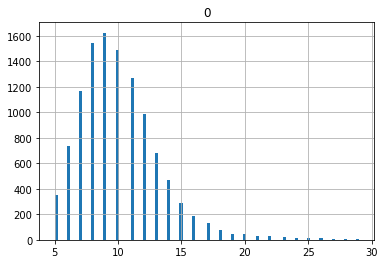

In [10]:
pd.DataFrame([len(x.split()) for x in messages]).hist(bins = 100)

В условии написано, что нельзя размечать тестовые данные, поэтому проверим присутствие уже существующих заголовков на их наличие в исходном датасете. Также проверим их наличие в тесте, чтоб не было задвоений

In [11]:
PATH_TO_TASK_FOLDER = "../input/fake-news-task"
train = pd.read_csv(os.path.join(PATH_TO_TASK_FOLDER,'train.tsv'), sep = '\t')
test = pd.read_csv(os.path.join(PATH_TO_TASK_FOLDER,'test.tsv'), sep = '\t')

In [12]:
data = train.append(test, ignore_index = True)['title'].values
data

array(['Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы',
       'Агент Кокорина назвал езду по встречке житейской историей',
       'Госдума рассмотрит возможность введения секретных статей Уголовного кодекса',
       ...,
       'СК возбудил дело против авиакомпании «Победа» за финансирование Навального',
       'Криптомонетный двор Туркменистана выпустил юбилейные биткоины',
       'Deutsche Bahn заплатит рекордный штраф за чтение писем сотрудников'],
      dtype=object)

Взял максимальную близость в 10 измененных символов и прошел за O(k*n), где k - собранные данные, n - уже имеющиеся. Вероятно, можно было бы ускорить выполнение подсчитав для каждого из предложений нормированный ембеддинг и перемоножив матрицу с новыми заголовками в строках на матрицу с эмбеддингами исходных заголовков в столбцах. Затем для каждой строки полученной матрицы взять максимальное значение и оставить только строки, не превосходящие пороговое значение.

In [13]:
DISTANCE_THRESHOLD = 10

def calculate_distance(word1, word2, distance_threshold = DISTANCE_THRESHOLD):
    return edlib.align(word1, word2, k = distance_threshold)['editDistance']

def get_unique_parsed_text(parsed_data, task_data, distance_threshold = DISTANCE_THRESHOLD):
    result = list()
    task_data = [x.lower().strip() for x in task_data]
    for i, parsed_text in tqdm(enumerate(map(lambda x: x.lower().strip(), parsed_data)), total = len(parsed_data)):
        seen = False
        for task_text in task_data:
            if 0 <= calculate_distance(parsed_text, task_text, distance_threshold) < distance_threshold:
                seen = True
                break
        if not seen:
            result.append(parsed_data[i])
    return result

parsed_long = get_unique_parsed_text(messages, data)

100%|██████████| 11226/11226 [58:07<00:00,  3.22it/s]


In [14]:
np.save('parsed_full', parsed_long)